In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [38]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43335 instead
  warnings.warn(


In [40]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/43489/status,
Dashboard: /proxy/43489/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.129:37217,Workers: 0
Dashboard: /proxy/43489/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s
upwelling_depth=-300
upwelling_cafe=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=upwelling_depth,method='nearest') #


upwelling=(upwelling_cafe.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=upwelling_depth,method='nearest')*area_m2)/1000000 # To Sverdrups
anthupwelling=(upwelling_cafe.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=upwelling_depth,method='nearest')*area_m2)/1000000 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)/1000000 # To Sverdrups
flux=((cafe_co2*-1)*area_m2)/1000000 # To Sverdrups

In [8]:
# Load Nics Initial Estimates (OLD, possibly wrong. But for comparison.

dic_tx_v_OLD=xr.open_dataset('../processed_data/dic_v.nc').__xarray_dataarray_variable__
dic_tx_u_OLD=xr.open_dataset('../processed_data/dic_u.nc').__xarray_dataarray_variable__
dic_tx_w_OLD=xr.open_dataset('../processed_data/dic_w.nc').__xarray_dataarray_variable__

anth_dic_tx_v_OLD=xr.open_dataset('../processed_data/dic_v_anth.nc').__xarray_dataarray_variable__
anth_dic_tx_u_OLD=xr.open_dataset('../processed_data/dic_u_anth.nc').__xarray_dataarray_variable__
anth_dic_tx_w_OLD=xr.open_dataset('../processed_data/dic_w_anth.nc').__xarray_dataarray_variable__

# Calculate M2 grid (NIC ATTEMPT) Just to cross compare the results.

def make_earth_grid_m2():
    boxlo,boxla=np.array(np.meshgrid(np.arange(0.5,359.5,1),np.arange(-89.5,89.5,1)))
    actual_grid=np.cos(np.radians(abs(boxla)))*(111.1*111.1*1000*1000)
    grid_nc=xr.DataArray(actual_grid,coords={'lat':boxla[:,1],'lon':boxlo[1,:]},dims=['lat','lon'])
    lat_size=110567 #in m
    grid_nc['area']=grid_nc#*lat_size
    grid_nc1=grid_nc['area']
    grid_nc1.name='m2'
    #grid_nc.to_netcdf('processed/earth_m2.nc',engine='h5netcdf',mode='w')
    return grid_nc1

lslice=slice(-3,3)

#grid.name='test'
#grid
model_dummy=phys_eqpac.temp
depths=model_dummy.sel(st_ocean=slice(0,500)).st_ocean.values
grid=make_earth_grid_m2().sel(lat=slice(-40,40),lon=slice(120,290)).to_dataset()
#grid.assign_coords(depth=depths.values)#['depths']=depths.values

#the m2 is actually wrong so regrid and adjust to cafe grid
rg=xe.Regridder(grid,model_dummy,"bilinear")# ds,dsout
rg_m=rg(grid)
grid_rg=(rg_m*(len(grid.lat)/len(model_dummy.lat))) # Normalise the m2 cells to their new sizes. 
grid_rg['lon_m']=[111100]*len(grid_rg.lon)#m, 111.11km

rglats=np.diff(grid_rg.lat)
rglats=np.append(rglats,rglats[-1]) #so they match size
                 
grid_rg['lat_m']=([111100]*len(grid_rg.lat))*rglats #m, 111.11km

grid_rg['depth']=-depths##.m2#.to_dataset()
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(grid_rg.depth):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
grid_rg['depth_diff']=depth_diffs
grid_rg['depth_m3']=grid_rg.m2*grid_rg.depth_diff
grid_rg['depth_lat_m2']=grid_rg.lat_m*grid_rg.depth_diff#np.sqrt(grid_rg['depth_m3']) # This should be precise enough on the equator right? Imagine further off boxes arent square.
grid_rg['depth_lon_m2']=grid_rg.lon_m*grid_rg.depth_diff#np.sqrt(grid_rg['depth_m3']) # This should be precise enough on the equator right? Imagine further off boxes arent square.

#grid_rg['name']='gridsize'
grid_rg_OLD=grid_rg
grid_rg_OLD
#np.diff(grid.depth.values,axis=0)#()#help(dep)  #.map()#grid.assign_coords(depths=depths)
#gridm2=grid.to_dataset()
#depths  

grid_multiplier_lon=grid_rg.depth_lon_m2
grid_multiplier_lon=grid_multiplier_lon.rename({'lon_m':'lon','depth_diff':'st_ocean'})
grid_multiplier_lon['lon']=grid_rg.lon
grid_multiplier_lon['st_ocean']=grid_rg.depth.values

grid_multiplier_lat=grid_rg.depth_lat_m2
grid_multiplier_lat=grid_multiplier_lat.rename({'lat_m':'lat','depth_diff':'st_ocean'})
grid_multiplier_lat['lat']=grid_rg.lat
grid_multiplier_lat['st_ocean']=grid_rg.depth.values



# -----
# Calculate Old Upwelling and Flux

anthupwelling_OLD=(anth_dic_tx_w_OLD.sel(st_ocean=300,method='nearest').sel(lat=lslice,lon=slice(150,270))*grid_rg.m2)/1000000
upwelling_OLD=(dic_tx_w_OLD.sel(st_ocean=300,method='nearest').sel(lat=lslice,lon=slice(150,270))*grid_rg.m2)/1000000

anthflux_OLD=(cafe_co2_anth*area_m2)/1000000 # To Sverdrups
flux_OLD=(cafe_co2*area_m2)/1000000 # To Sverdrups

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/core.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xesmf/smm.py:129: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


### Check some of the vars to make sure they look ok

In [9]:
adic_cafe

<xarray.DataArray 'adic' (time: 720, st_ocean: 26, lat: 140, lon: 170)>
[445536000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [10]:
dic_cafe

<xarray.DataArray 'dic' (time: 720, st_ocean: 26, lat: 140, lon: 170)>
[445536000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [11]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

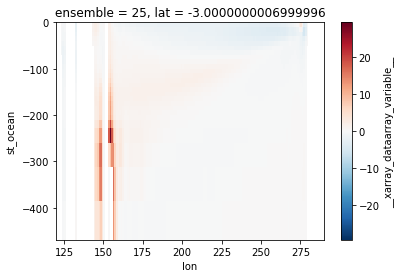

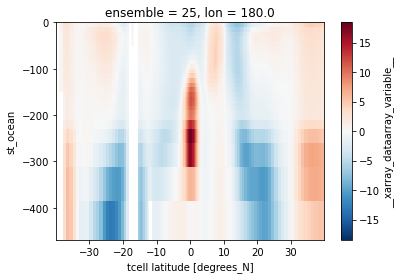

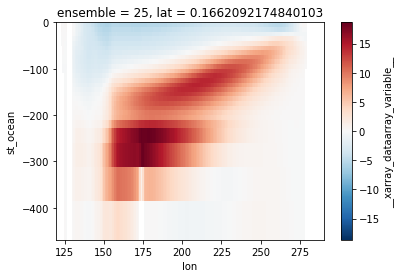

In [12]:
# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe','dic_cafe']
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'})
        tracer_v=tracer.rename({'lat':'lat_x'})

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=True
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport.nc')
        print('v saved')
        
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK

#chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
plt.show()
anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
plt.show()
anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

## Calculate ENSO Months

In [13]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [14]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(ds,cutoff=0,mean=True,printer=True):
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(np.array(res))
    return np.array(res)

In [15]:
dic_transport_through_box=pd.DataFrame()

# Start the Figures

### Plot 1 and 2: North and South Faces

[ 0.87532756 -0.92866429]
[ 0.7647802  -1.30194908]
[ 0.8719381  -1.13174924]
[ 0.99230267 -0.84639342]


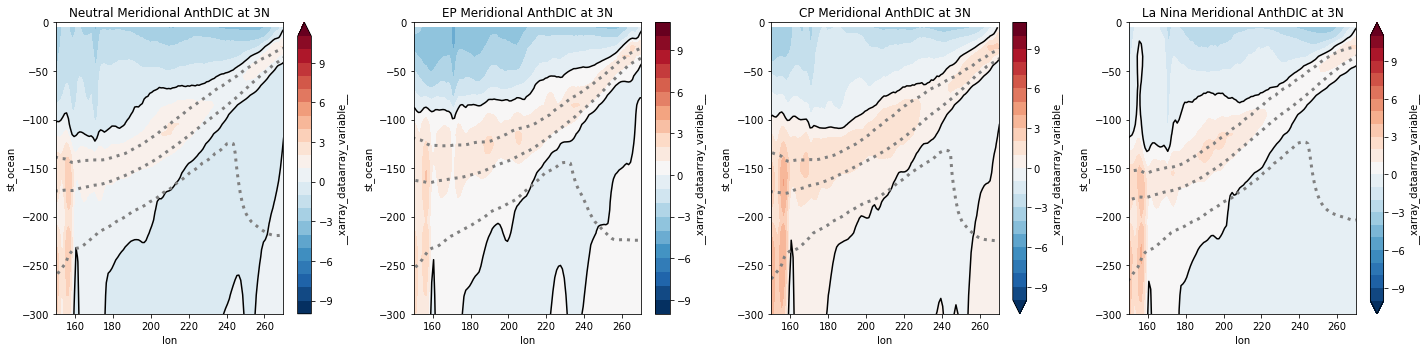

[ 1.45942384 -1.04298294]
[ 1.29253092 -1.16515732]
[ 1.3565781  -1.10854468]
[ 1.88287779 -0.96791231]


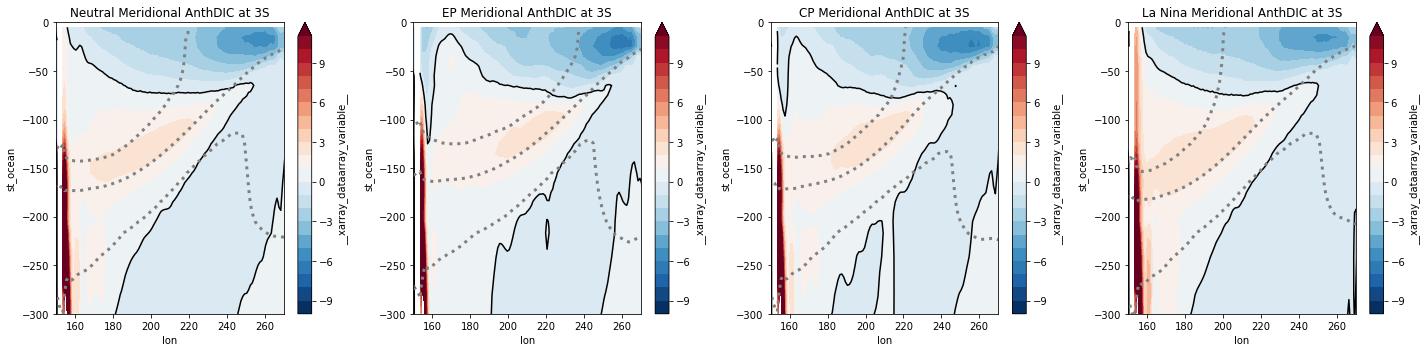

[ 39.00683767 -36.83446751]
[ 33.14764178 -45.45435676]
[ 38.53201998 -43.67203059]
[ 45.16484377 -35.98119466]


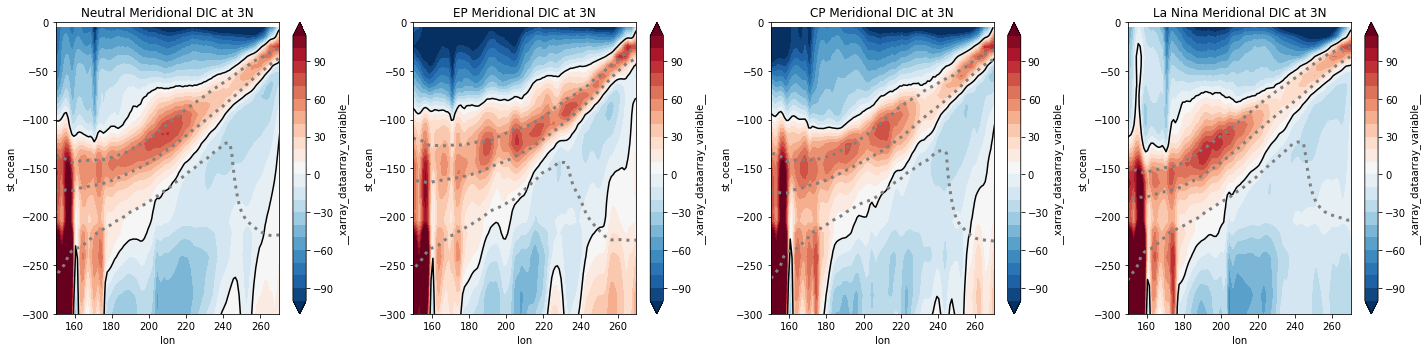

[ 60.44016058 -43.54932231]
[ 51.69355855 -45.30713478]
[ 56.99382106 -44.5026952 ]
[ 78.33404361 -42.7170015 ]


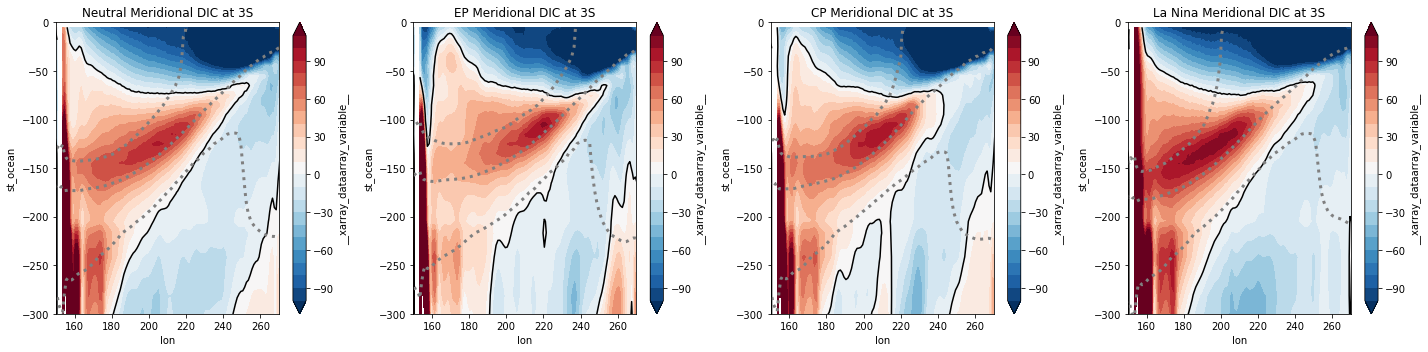

[ 0.84128707 -0.85985366]
[ 1.15990546 -0.76948373]
[ 1.01737025 -0.86576624]
[ 0.76293947 -0.98728958]


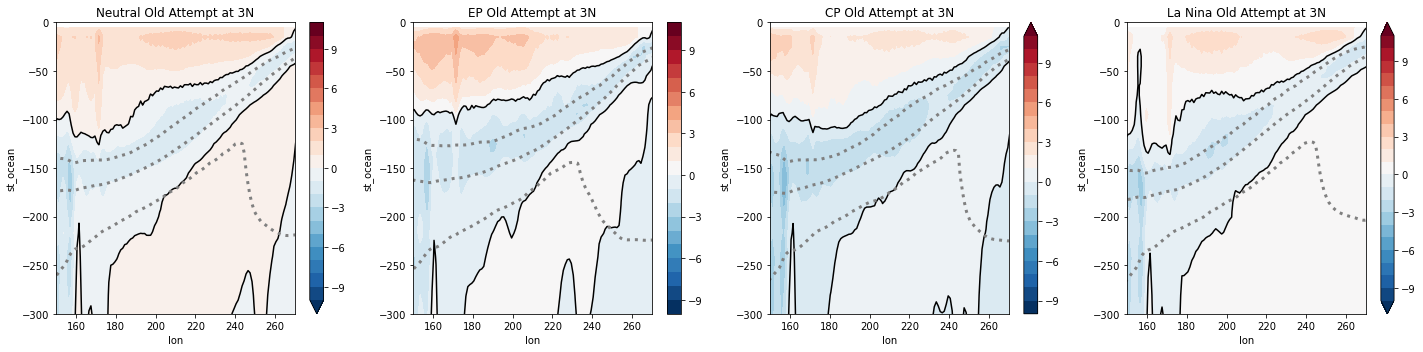

[ 0.94093886 -1.35876205]
[ 1.05652065 -1.20215442]
[ 1.00546997 -1.25370496]
[ 0.8710343 -1.7534197]


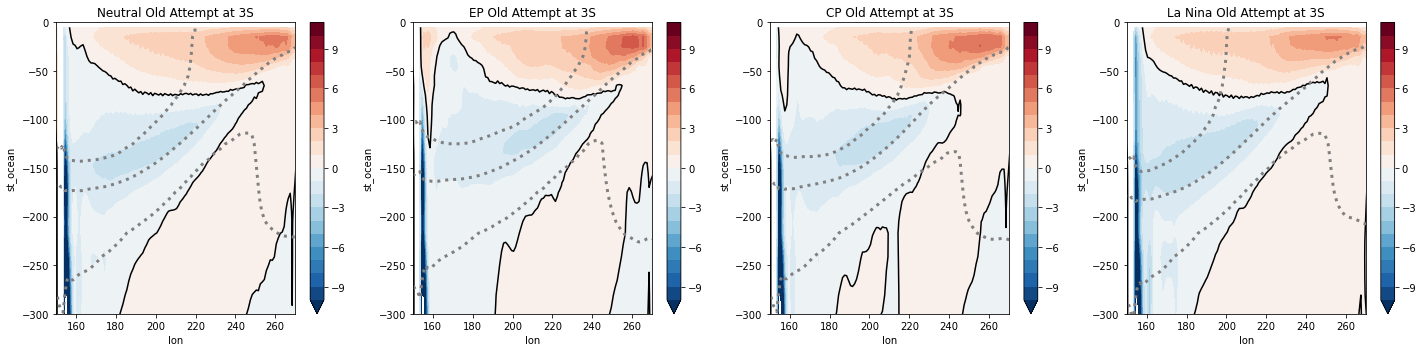

,Neutral,EP,CP,Nina
Meridional AnthDIC in 3N,0.875328,0.764780,0.871938,0.992303
Meridional AnthDIC out 3N,-0.928664,-1.301949,-1.131749,-0.846393
Meridional AnthDIC in 3S,1.459424,1.292531,1.356578,1.882878
Meridional AnthDIC out 3S,-1.042983,-1.165157,-1.108545,-0.967912
Meridional DIC in 3N,39.006838,33.147642,38.532020,45.164844
Meridional DIC out 3N,-36.834468,-45.454357,-43.672031,-35.981195
Meridional DIC in 3S,60.440161,51.693559,56.993821,78.334044
Meridional DIC out 3S,-43.549322,-45.307135,-44.502695,-42.717002
Old Attempt in 3N,0.841287,1.159905,1.017370,0.762939
Old Attempt out 3N,-0.859854,-0.769484,-0.865766,-0.987290


In [16]:
plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500)),
                     dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500))],
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):


        for lat in [3,-3]:
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3S'

            plt.figure(figsize=(20,5))
            plt.subplot(141)
            if ((i==0)|(i==2)): 
                levs=np.arange(-10,12,1)#-1e7,1e7,1e6)
            elif i==1: 
                levs=np.arange(-100,120,10)#-1e7,1e7,1e6)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]

           

            plt.subplot(141)        
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_n.sel(time=neutral_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([-300,0])

            plt.subplot(142)
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_n.sel(time=ep_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([-300,0])


            plt.subplot(143)
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_n.sel(time=cp_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

            plt.title(f'CP {N_S_names[i]} at {direct}')

            plt.xlim([150,270])
            plt.ylim([-300,0])

            plt.subplot(144)
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_n.sel(time=nina_events).mean(dim='time'))
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([-300,0])
            plt.tight_layout()

            plt.show()
           
            temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
dic_transport_through_box                                     

### Plot 3+4: Western and Eastern Faces

[ 3.32632965 -2.91616626]
[ 3.38367201 -3.3917215 ]
[ 3.1988479  -3.11617456]
[ 3.2436468  -2.83534214]


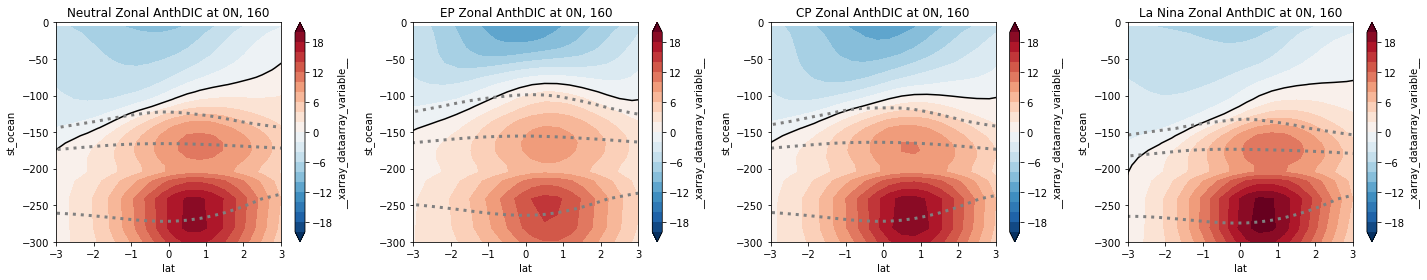

[ 1.44668374 -1.13270068]
[ 1.54303792 -1.24666791]
[ 1.55902774 -1.13601582]
[ 1.42791359 -1.12146495]


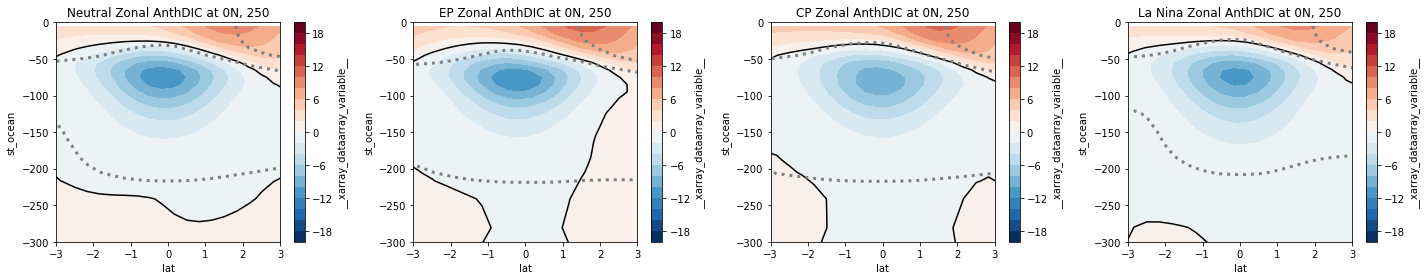

[ 130.52491911 -104.8545647 ]
[ 122.3727913  -114.82476456]
[ 127.23843578 -113.58243237]
[ 131.70651916 -105.70686979]


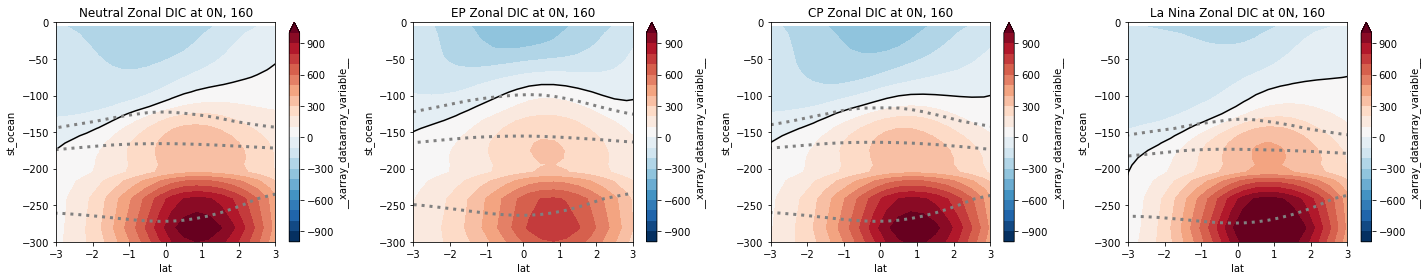

[ 58.52373672 -50.97041756]
[ 60.42575501 -52.48678571]
[ 62.99082949 -51.75427852]
[ 58.5747081  -55.72893252]


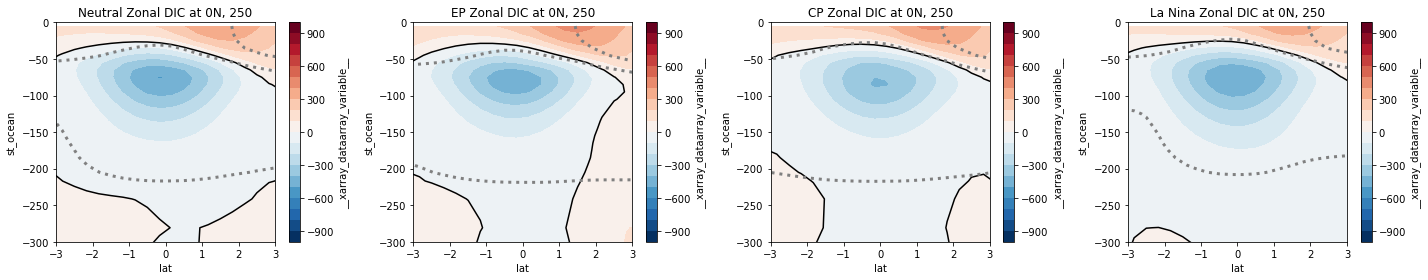

In [17]:
plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500)),
                     dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):

        lons=[160,250]
        for lon in lons:
            if i==0 or i==2:
                levs=np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=np.arange(-1000,1100,100)
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            #lon=180
            lslice=slice(-3,3)


            plt.figure(figsize=(20,4))
            #plt.subplot(251)
            plt.subplot(141)

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(st_ocean=slice(0,-500))#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest').sel(lat=lslice)#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b.sel(time=neutral_events).mean(dim='time'))

            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([-300,0])
            plt.xlim([-3,3])

            plt.subplot(142)
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b.sel(time=ep_events).mean(dim='time'))
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([-300,0])
            plt.xlim([-3,3])

            plt.subplot(143)
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b.sel(time=cp_events).mean(dim='time'))
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([-300,0])
            plt.xlim([-3,3])

            plt.subplot(144)
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b.sel(time=nina_events).mean(dim='time'))
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([-300,0])
            plt.xlim([-3,3])


            plt.tight_layout()
            plt.show()
            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{E_W_names[i]} in {lon}',f'{E_W_names[i]} out {lon}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            temp_holder

In [18]:
dic_transport_through_box

,Neutral,EP,CP,Nina
Meridional AnthDIC in 3N,0.875328,0.764780,0.871938,0.992303
Meridional AnthDIC out 3N,-0.928664,-1.301949,-1.131749,-0.846393
Meridional AnthDIC in 3S,1.459424,1.292531,1.356578,1.882878
Meridional AnthDIC out 3S,-1.042983,-1.165157,-1.108545,-0.967912
Meridional DIC in 3N,39.006838,33.147642,38.532020,45.164844
Meridional DIC out 3N,-36.834468,-45.454357,-43.672031,-35.981195
Meridional DIC in 3S,60.440161,51.693559,56.993821,78.334044
Meridional DIC out 3S,-43.549322,-45.307135,-44.502695,-42.717002
Old Attempt in 3N,0.841287,1.159905,1.017370,0.762939
Old Attempt out 3N,-0.859854,-0.769484,-0.865766,-0.987290



### Plot 3+4: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling
anthupwelling_OLD
upwelling_OLD

flux
anthflux
flux_OLD
anthflux_OLD

[ 13.1509835  -17.72957137]
[ 16.91077145 -16.27174927]
[ 17.38105669 -18.4689588 ]
[13.42630811 -9.27902136]


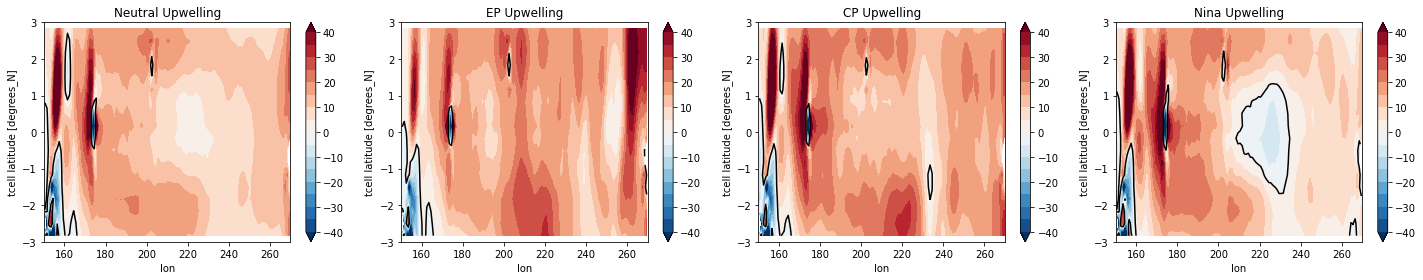

[ 0.17781931 -0.33419571]
[ 0.21764657 -0.30790949]
[ 0.2360907  -0.32773294]
[ 0.18662523 -0.1618654 ]


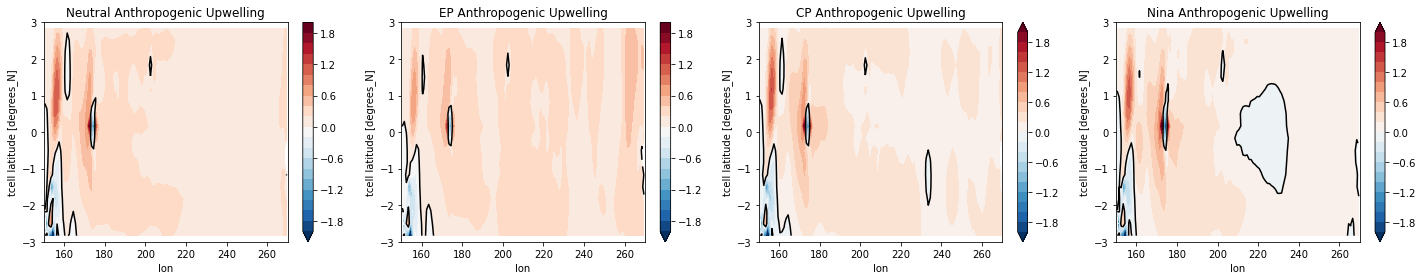

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0.1972104       nan]
[0.17662542        nan]


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0.18755605        nan]
[0.18690293        nan]


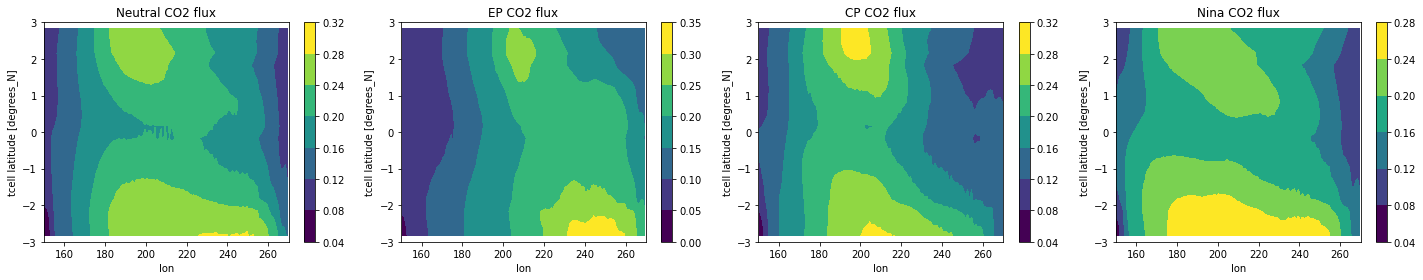

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[        nan -0.05442933]
[        nan -0.05295366]


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[        nan -0.04908257]
[        nan -0.05892848]


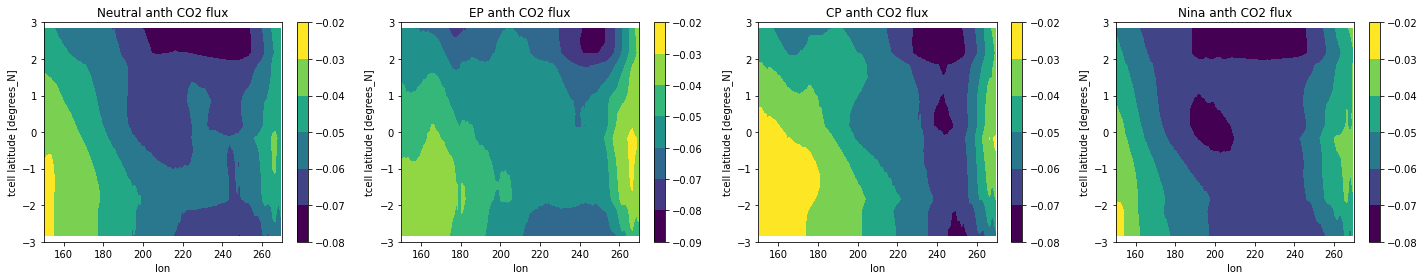

In [41]:
plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling.sel(time=slice('2000-01-01','2020-01-01')),
                     #upwelling_OLD.sel(time=slice('2000-01-01','2020-01-01')),
                     #anthupwelling_OLD.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     flux.sel(time=slice('2000-01-01','2020-01-01')),
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))]#,
                     #flux_OLD.sel(time=slice('2000-01-01','2020-01-01')),
                     #anthflux_OLD.sel(time=slice('2000-01-01','2020-01-01'))]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling','Anthropogenic Upwelling','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=np.arange(-40,45,5)
        elif i==1:
            levs=np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).mean(dim='time'))

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat.sel(time=ep_events).mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat.sel(time=cp_events).mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat.sel(time=nina_events).mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [42]:
dic_transport_through_box#=dic_transport_through_box[:-8]

,Neutral,EP,CP,Nina
Meridional AnthDIC in 3N,0.875328,0.764780,0.871938,0.992303
Meridional AnthDIC out 3N,-0.928664,-1.301949,-1.131749,-0.846393
Meridional AnthDIC in 3S,1.459424,1.292531,1.356578,1.882878
Meridional AnthDIC out 3S,-1.042983,-1.165157,-1.108545,-0.967912
Meridional DIC in 3N,39.006838,33.147642,38.532020,45.164844
Meridional DIC out 3N,-36.834468,-45.454357,-43.672031,-35.981195
Meridional DIC in 3S,60.440161,51.693559,56.993821,78.334044
Meridional DIC out 3S,-43.549322,-45.307135,-44.502695,-42.717002
Old Attempt in 3N,0.841287,1.159905,1.017370,0.762939
Old Attempt out 3N,-0.859854,-0.769484,-0.865766,-0.987290


In [43]:
dic_transport_through_box.to_csv('dic_tx.csv')

## End Box Estimate

In [22]:
# Do some checks/tests.

In [44]:
dic_transport_through_box=pd.read_csv('dic_tx.csv',index_col=0)

names=dic_transport_through_box.index

old_tx=dic_transport_through_box[names.str.lower().str.contains('old')]
old_tx_anth=old_tx[old_tx.index.str.lower().str.contains('anth')]
for anth in old_tx_anth.index:
    if anth in old_tx.index:
        old_tx=old_tx.drop(anth)
        
new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)

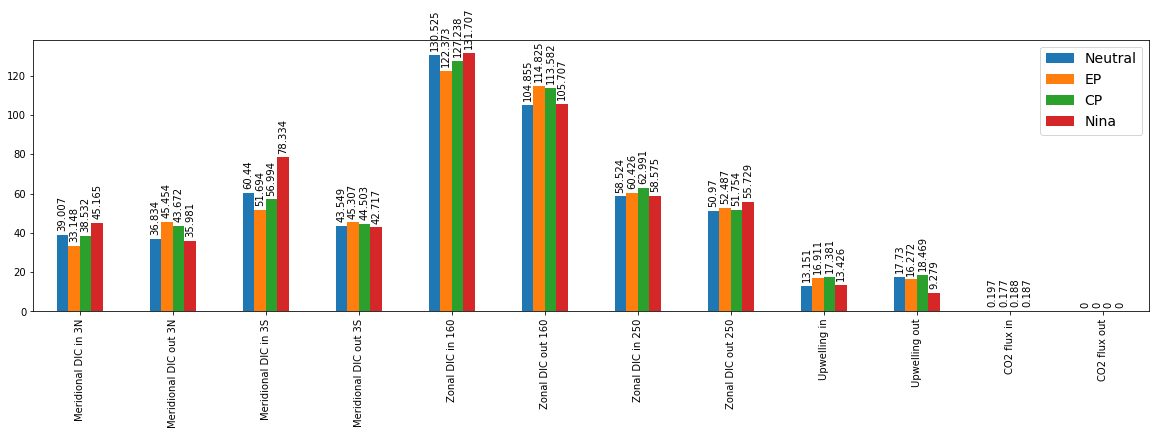

In [49]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

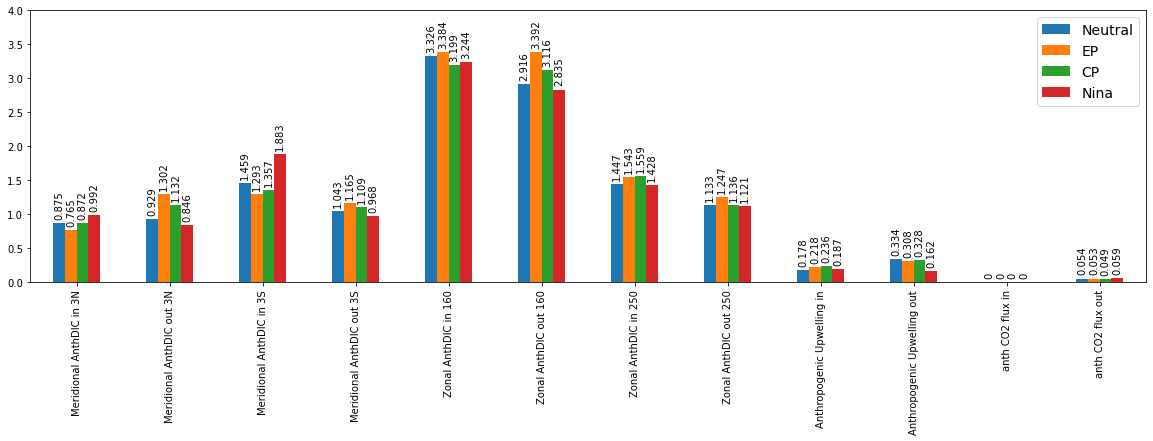

In [50]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [51]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
    print(box_res)
    print(box_res.mean())

Total DIC transport
             Neutral        EP        CP       Nina
3s          8.445419  3.193212  6.245563  17.808521
3n          1.086185 -6.153357 -2.570005   4.591825
160        12.835177  3.774013  6.828002  12.999825
250         3.776660  3.969485  5.618275   1.422888
upwelling  -2.289294  0.319511 -0.543951   2.073643
flux        0.197210  0.176625  0.187556   0.186903
Neutral    4.008560
EP         0.879915
CP         2.627573
Nina       6.513934
dtype: float64
Anth DIC transport
            Neutral        EP        CP      Nina
3s         0.208220  0.063687  0.124017  0.457483
3n        -0.026668 -0.268584 -0.129906  0.072955
160        0.205082 -0.004025  0.041337  0.204152
250        0.156992  0.148185  0.211506  0.153224
upwelling -0.078188 -0.045131 -0.045821  0.012380
flux      -0.054429 -0.052954 -0.049083 -0.058928
Neutral    0.068501
EP        -0.026470
CP         0.025342
Nina       0.140211
dtype: float64


In [52]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

Total DIC transport  out
       Neutral         EP         CP       Nina
in   50.307308  47.454524  50.553953  54.565554
out -50.787669 -54.868958 -54.396079 -49.882604
Neutral   -0.240180
EP        -3.707217
CP        -1.921063
Nina       2.341475
dtype: float64
Anth DIC transport  out
      Neutral        EP        CP      Nina
in   1.457117  1.440334  1.444497  1.546673
out -1.068190 -1.244393 -1.144883 -0.998651
Neutral    0.194463
EP         0.097970
CP         0.149807
Nina       0.274011
dtype: float64


In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth